In [ ]:
#@title Clone and install our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!git -C unitree-go2-mjx-rl checkout rnn-support
!pip install -e unitree-go2-mjx-rl

In [1]:
!pip show jax

Name: jax
Version: 0.5.1
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/jax-ml/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: jaxlib, ml_dtypes, numpy, opt_einsum, scipy
Required-by: chex, dopamine_rl, flax, mujoco-mjx, optax, orbax-checkpoint, quadruped_mjx_rl


In [ ]:
#@title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

In [4]:
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} checkout rnn-support

Branch 'rnn-support' set up to track remote branch 'rnn-support' from 'origin'.
Switched to a new branch 'rnn-support'


INFO:root:Logging switched on.


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


""

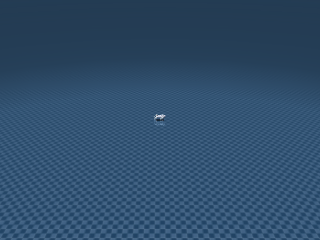

Setup finished, initializing the environment...


INFO:2025-12-08 13:52:21,183:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-12-08 13:52:21,294:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Params restored, starting training...
INFO:root:Device count: 1, process count: 1 (id 0), local device count: 1, devices to be used co

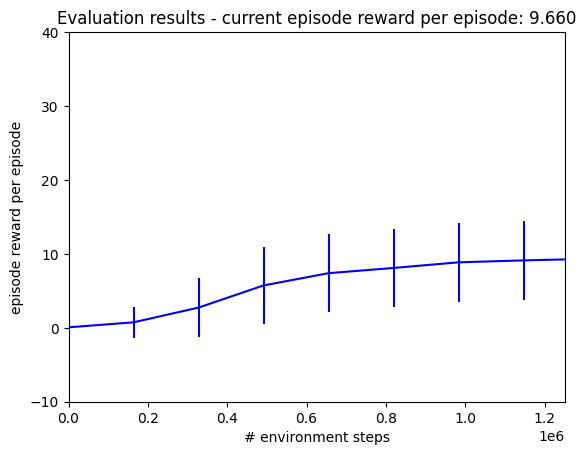

INFO:root:Setup took 35.47544836997986
INFO:root:current_step: 0
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root: eval/episode_reward: 0.06571466475725174
INFO:root: eval/episode_reward_std: 0.9887553453445435
INFO:root:current_step: 0
INFO:root:starting iteration 0 90.74761056900024
INFO:root:training_metrics: {'training/sps': np.float64(2849.73419768575), 'training/walltime': 57.49308133125305, 'training/entropy_loss': Array(-0.077, dtype=float32), 'training/policy_loss': Array(-0.023, dtype=float32), 'training/total_loss': Array(-0.099, dtype=float32), 'training/v_loss': Array(0.001, dtype=float32)}
INFO:root:current_step: 163840
INFO:root: eval/episode_reward: 0.7410916686058044
INFO:root: eval/episode_reward_std: 2.0934505462646484
INFO:root:current_step: 163840
INFO:root:starting iteration 1 175.58433294296265
INFO:root:training_metrics: {'training/sps': np.float64(58438.21883170634), 'training/walltime': 60.2967259

In [1]:
#@title Session setup

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

# Check if MuJoCo installation was successful
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
configs_path = repo_path / "configs"
scenes_path = repo_path / "resources" / "unitree_go2"
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

# Prepare configs
from quadruped_mjx_rl.robots import predefined_robot_configs
robot_config = predefined_robot_configs["unitree_go2"]()

from quadruped_mjx_rl.environments import JoystickBaseEnvConfig
env_config = JoystickBaseEnvConfig()

from quadruped_mjx_rl.models import ActorCriticConfig, ModuleConfigMLP
model_config = ActorCriticConfig(
    policy=ModuleConfigMLP(layer_sizes=[128, 128, 128, 128]),
    value=ModuleConfigMLP(layer_sizes=[256, 256, 256, 256]),
)

from quadruped_mjx_rl.training.configs import TrainingConfig
training_config = TrainingConfig(
    num_timesteps=1_000_000, num_envs=2048, num_eval_envs=2048, batch_size=256
)

# Set up the terrain
init_scene_path = scenes_path / "scene_mjx.xml"

from quadruped_mjx_rl.environments.physics_pipeline import load_to_spec, spec_to_model
env_spec = load_to_spec(init_scene_path)
env_model = spec_to_model(env_spec)

# Render the situation
import mujoco
from quadruped_mjx_rl.environments.rendering import large_overview_camera, render_model, show_image
image = render_model(
    env_model=env_model,
    initial_keyframe=robot_config.initial_keyframe,
    camera=large_overview_camera(),
)
show_image(image)


from quadruped_mjx_rl.environments import get_env_factory
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_model=env_model,
    customize_model=True,
)

# Create the environment
print("Setup finished, initializing the environment...")
env = env_factory()
eval_env = env_factory()

# Checkpointing
from quadruped_mjx_rl.models.io import save_params, load_params
use_restored_params = False  #@param {"type":"boolean"}
restore_params = load_params(results_path / "resulting_params") if use_restored_params else None
logging.info("Params restored, starting training...")

# Launch training
from quadruped_mjx_rl.training.train_interface import train
params = train(
    training_config=training_config,
    model_config=model_config,
    training_env=env,
    evaluation_env=eval_env,
    restore_params=restore_params,
)

save_params(results_path / "resulting_params", params)

In [2]:
!pip show mujoco

Name: mujoco
Version: 3.3.4
Summary: MuJoCo Physics Simulator
Home-page: https://github.com/google-deepmind/mujoco
Author: 
Author-email: Google DeepMind <mujoco@deepmind.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, etils, glfw, numpy, pyopengl
Required-by: mujoco-mjx, quadruped_mjx_rl
